In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

with open('/home/davide/Desktop/phd/hawkes/data/file_densities_map.json') as f:
    config = json.load(f)


df_map = {
    'timestamp': [],
    'timestamp_density': [],
    'density': [],
}

for k, v in config.items():
    num_densities = len(v)
    timestamp = k.split('_')[2].split('.')[0]
    df_map['timestamp'].extend([float(timestamp)] * num_densities)

    for info_density in v:
        df_map['timestamp_density'].append(pd.Timestamp(info_density[0]).strftime('%H%M%S'))
        df_map['density'].append(int(info_density[1]))

df_map = pd.DataFrame(df_map)
df_map.sort_values(by=['density'], inplace=True, ascending=False)

best_df = df_map.iloc[0:67]
best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))
best_df.head()

/tmp/ipykernel_4652/4065846239.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))


,timestamp,timestamp_density,density
126,1705076796365,161544,119
139,1706027368287,154315,118
18,1705268954407,212428,116
120,1705925395390,102636,116
38,1705074061033,151951,115


## Sensitivity Hawkes

In [4]:
best_df = pd.read_csv('/home/davide/Desktop/phd/hawkes/data/best_densities.csv')
best_df.head()

,timestamp,timestamp_density,density
0,1705076796365,161544,119
1,1706027368287,154315,118
2,1705268954407,212428,116
3,1705925395390,102636,116
4,1705074061033,151951,115


In [5]:
result_file_paths = [
    (i,f"/home/davide/Desktop/phd/hawkes/data_{i}min_training/results_all_{i}min.tsv")
    for i in [5,10,15,20]
]

dfs = []
for i, result_file_path in result_file_paths:
    df = pd.read_csv(result_file_path, sep='\t')
    df['training_minutes'] = i
    df = df[df['method_time_prediction'] == 'hawkes']
    dfs.append(df)

df = pd.concat(dfs)
plot_df = df[df['timestamp'].isin(best_df['timestamp']) & (df['timestamp_density'].isin(best_df['timestamp_density']))]
plot_df.head()

,timestamp,timestamp_density,method_time_prediction,bi_level,accuracy,returns,training_minutes
0,1.705074e+12,151951.0,hawkes,8,0.643564,22.025213,5
3,1.705077e+12,161544.0,hawkes,8,0.485714,-20.620770,5
6,1.705165e+12,163845.0,hawkes,8,0.444444,-24.612985,5
9,1.705168e+12,174206.0,hawkes,8,0.391304,-48.496684,5
33,1.705262e+12,193416.0,hawkes,8,0.566265,15.224383,5


In [21]:
best_df[~(best_df['timestamp'].isin(df['timestamp']) & (best_df['timestamp_density'].isin(df['timestamp_density'])))]

,timestamp,timestamp_density,density


In [22]:
plot_df['training_minutes'].value_counts()

5     50
10    50
20    50
Name: training_minutes, dtype: int64

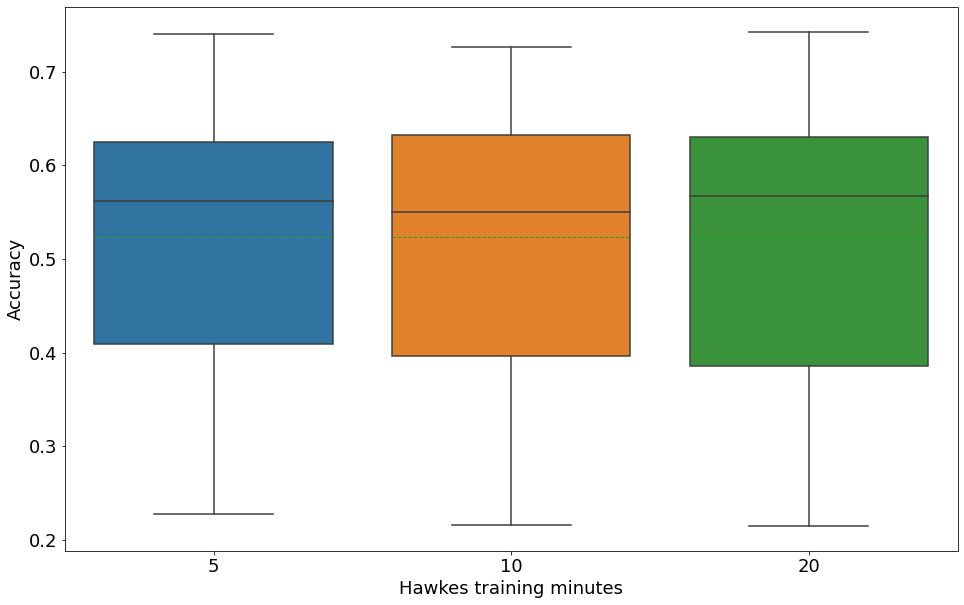

In [23]:
# boxplot
plt.rcParams["figure.figsize"] = (16,10)
sns.boxplot(x='training_minutes', y='accuracy', data=plot_df,showmeans=True, meanline=True)
# increase font size
#increase plot size
plt.rcParams.update({'font.size': 18})

plt.xlabel('Hawkes training minutes')
plt.ylabel('Accuracy')
#put white background
sns.set_style("whitegrid")

## Sensitivity Moving Average

In [10]:
moving_average_df = pd.read_csv('/home/davide/Desktop/phd/hawkes/data_moving_average_windows_results/results_all_movingaverage_BI8.tsv', sep='\t')
moving_average_df.head()

,timestamp,timestamp_density,seconds,bi_level,accuracy,returns
0,1.705074e+12,151951.0,120.0,8,0.616667,25.689636
1,1.705074e+12,151951.0,180.0,8,0.625000,26.801633
2,1.705074e+12,151951.0,240.0,8,0.641667,29.915461
3,1.705074e+12,151951.0,30.0,8,0.583333,19.012572
4,1.705074e+12,151951.0,60.0,8,0.608333,22.686357


In [11]:
plot_df = moving_average_df[moving_average_df['timestamp'].isin(best_df['timestamp']) & (moving_average_df['timestamp_density'].isin(best_df['timestamp_density']))]
plot_df.head()

,timestamp,timestamp_density,seconds,bi_level,accuracy,returns
0,1.705074e+12,151951.0,120.0,8,0.616667,25.689636
1,1.705074e+12,151951.0,180.0,8,0.625000,26.801633
2,1.705074e+12,151951.0,240.0,8,0.641667,29.915461
3,1.705074e+12,151951.0,30.0,8,0.583333,19.012572
4,1.705074e+12,151951.0,60.0,8,0.608333,22.686357


In [12]:
plot_df['seconds'].value_counts()

120.0    50
180.0    50
240.0    50
30.0     50
60.0     50
Name: seconds, dtype: int64

In [15]:
plot_df.groupby('seconds')['accuracy'].mean()

seconds
30.0     0.529735
60.0     0.524237
120.0    0.524167
180.0    0.518000
240.0    0.524500
Name: accuracy, dtype: float64

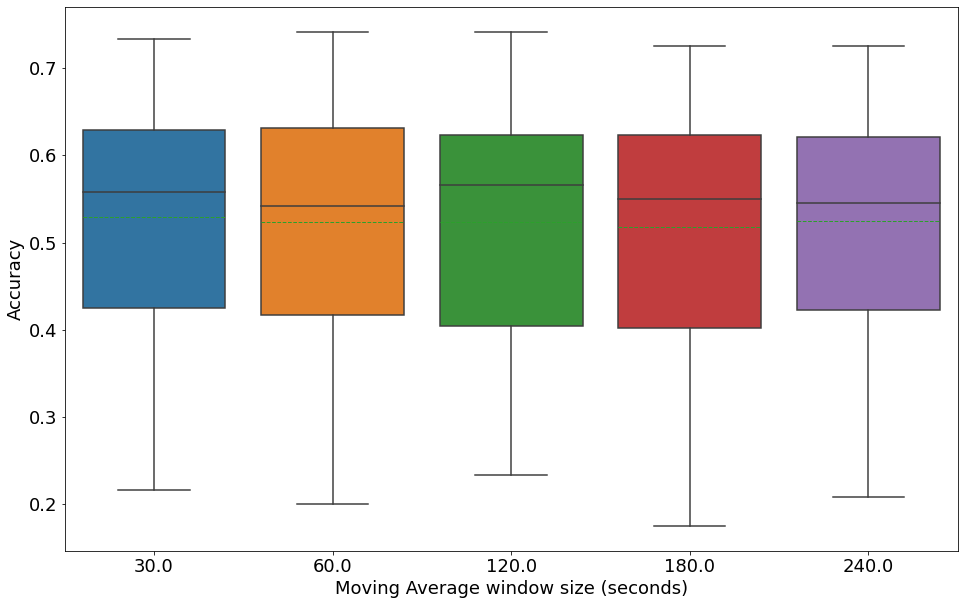

In [13]:
# boxplot
plt.rcParams["figure.figsize"] = (16,10)
sns.boxplot(x='seconds', y='accuracy', data=plot_df,showmeans=True, meanline=True)
# increase font size
#increase plot size
plt.rcParams.update({'font.size': 18})

plt.xlabel('Moving Average window size (seconds)')
plt.ylabel('Accuracy')
#put white background
sns.set_style("whitegrid")

## Accuracy

In [28]:
df = pd.read_csv('/home/davide/Desktop/phd/hawkes/data_20min_training/results_all_20min.tsv', sep='\t')
df = df[df['method_time_prediction'] != 'movingaverage']
df.sort_values(by=['timestamp', 'timestamp_density'], inplace=True)

df.dropna(inplace=True)
df.head()

,timestamp,timestamp_density,method_time_prediction,bi_level,accuracy,returns
0,1.705074e+12,151951.0,hawkes,8,0.588235,16.021835
1,1.705074e+12,151951.0,naive,8,0.628099,31.022824
2,1.705074e+12,151951.0,oracle,8,0.587719,24.467495
3,1.705077e+12,161544.0,hawkes,8,0.480769,-15.063808
4,1.705077e+12,161544.0,naive,8,0.454545,-31.939553


In [29]:
plot_df = df[df['timestamp'].isin(best_df['timestamp']) & (df['timestamp_density'].isin(best_df['timestamp_density']))]
plot_df.head()

,timestamp,timestamp_density,method_time_prediction,bi_level,accuracy,returns
0,1.705074e+12,151951.0,hawkes,8,0.588235,16.021835
1,1.705074e+12,151951.0,naive,8,0.628099,31.022824
2,1.705074e+12,151951.0,oracle,8,0.587719,24.467495
3,1.705077e+12,161544.0,hawkes,8,0.480769,-15.063808
4,1.705077e+12,161544.0,naive,8,0.454545,-31.939553


In [30]:
plot_df['method_time_prediction'].value_counts()

hawkes    50
naive     50
oracle    50
Name: method_time_prediction, dtype: int64

In [31]:
densities=plot_df.groupby(['timestamp', 'timestamp_density']).agg({'method_time_prediction': list})
a=densities[densities['method_time_prediction'].apply(lambda x: len(x)) < 3].reset_index()
a['timestamp_density'] = a['timestamp_density'].apply(lambda x: int(x))
a['timestamp'] = a['timestamp'].apply(lambda x: int(x))
a

,timestamp,timestamp_density,method_time_prediction


In [32]:
plot_df=plot_df[['method_time_prediction', 'accuracy', 'returns']]
moving_average_df=moving_average_df[moving_average_df['seconds'] == 30].copy()
moving_average_df['method_time_prediction'] = 'movingaverage'
plot_df = pd.concat([plot_df, moving_average_df[['method_time_prediction', 'accuracy', 'returns']]])

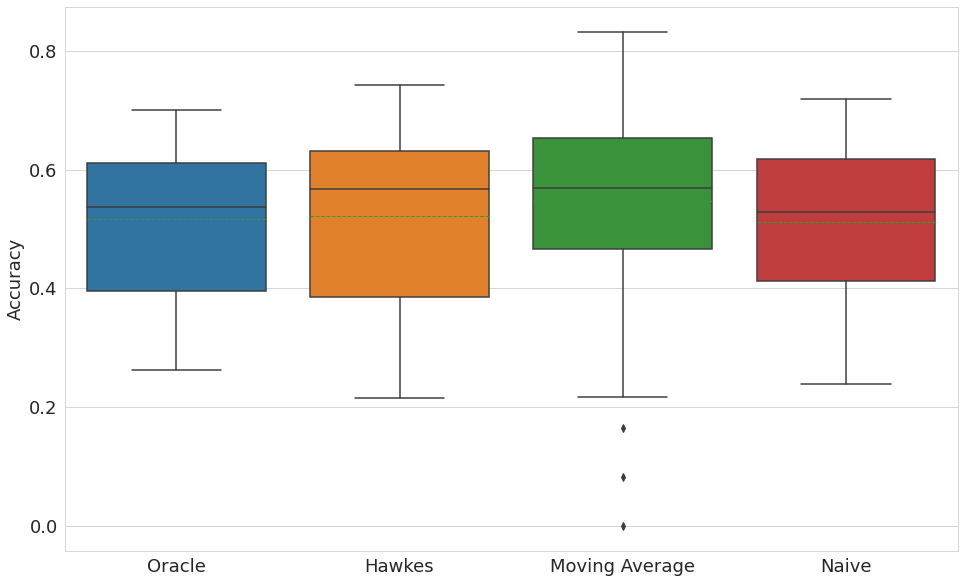

In [33]:
plt.rcParams["figure.figsize"] = (16,10)
order = ['oracle', 'hawkes', 'movingaverage', 'naive']
sns.boxplot(x='method_time_prediction', y='accuracy', data=plot_df, order=order, showmeans=True, meanline=True)
#increase plot size
plt.ylabel('Accuracy')
plt.rcParams.update({'font.size': 18})
# delete x label
plt.xlabel('')
# set x ticks labels
plt.xticks([0, 1, 2, 3], ['Oracle', 'Hawkes', 'Moving Average', 'Naive'])
plt.show()

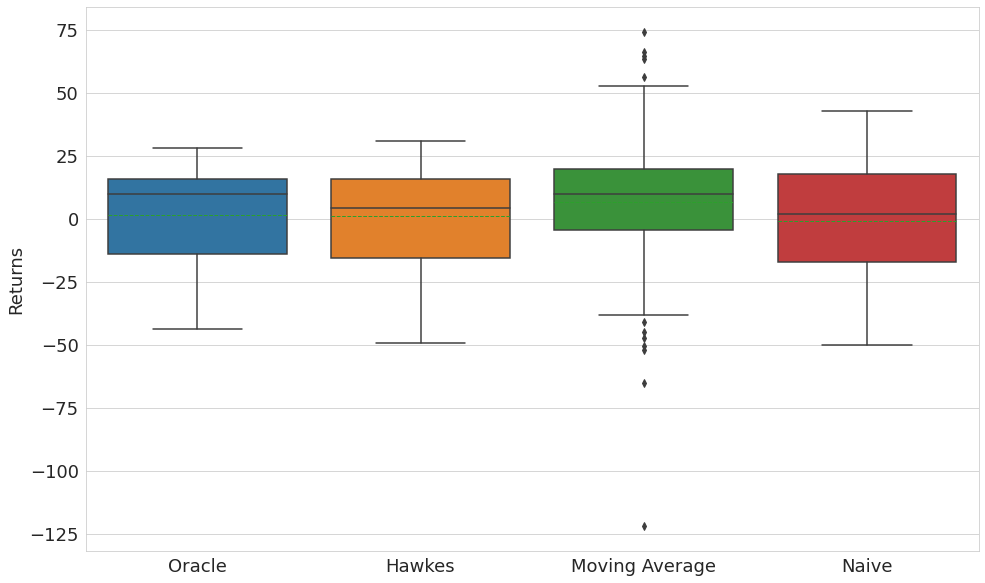

In [34]:
plt.rcParams["figure.figsize"] = (16,10)
order = ['oracle', 'hawkes', 'movingaverage', 'naive']
sns.boxplot(x='method_time_prediction', y='returns', data=plot_df, order=order, showmeans=True, meanline=True)
#increase plot size
plt.ylabel('Returns')
plt.rcParams.update({'font.size': 18})
# delete x label
plt.xlabel('')
# set x ticks labels
plt.xticks([0, 1, 2, 3], ['Oracle', 'Hawkes', 'Moving Average', 'Naive'])
plt.show()

In [18]:
df = pd.read_csv('//home/davide/Desktop/phd/hawkes/data_20min_training_with_ma/results_all_20min.tsv', sep='\t')
df.sort_values(by=['timestamp', 'timestamp_density'], inplace=True)
df.dropna(inplace=True)
plot_df = df[df['timestamp'].isin(best_df['timestamp']) & (df['timestamp_density'].isin(best_df['timestamp_density']))]
plot_df.head()

,timestamp,timestamp_density,method_time_prediction,bi_level,accuracy,returns
0,1.705074e+12,151951.0,hawkes,8,0.588235,16.021835
1,1.705074e+12,151951.0,movingaverage,8,0.616667,25.689636
2,1.705074e+12,151951.0,naive,8,0.628099,31.022824
3,1.705074e+12,151951.0,oracle,8,0.587719,24.467495
4,1.705077e+12,161544.0,hawkes,8,0.480769,-15.063808


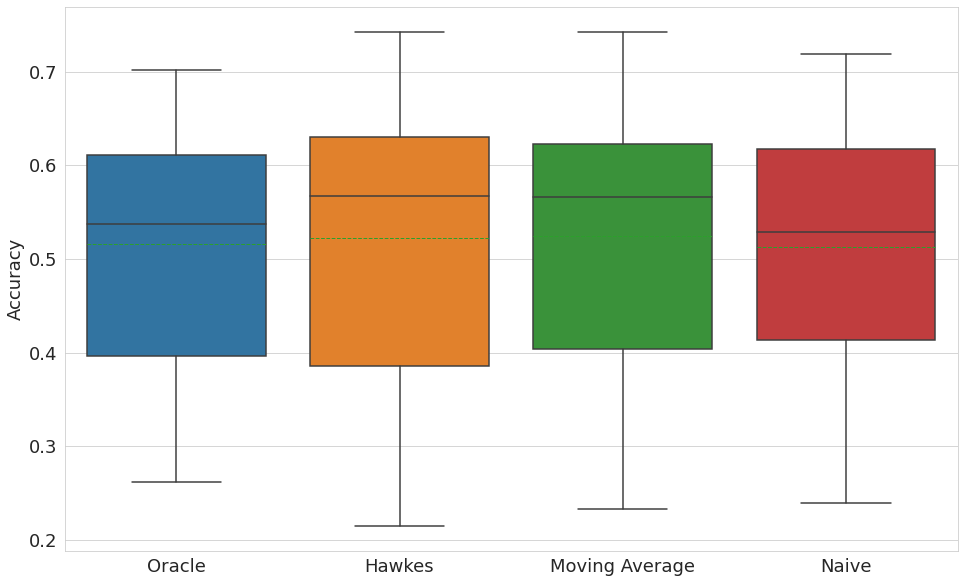

In [19]:
plt.rcParams["figure.figsize"] = (16,10)
order = ['oracle', 'hawkes', 'movingaverage', 'naive']
sns.boxplot(x='method_time_prediction', y='accuracy', data=plot_df, order=order, showmeans=True, meanline=True)
#increase plot size
plt.ylabel('Accuracy')
plt.rcParams.update({'font.size': 18})
# delete x label
plt.xlabel('')
# set x ticks labels
plt.xticks([0, 1, 2, 3], ['Oracle', 'Hawkes', 'Moving Average', 'Naive'])
plt.show()

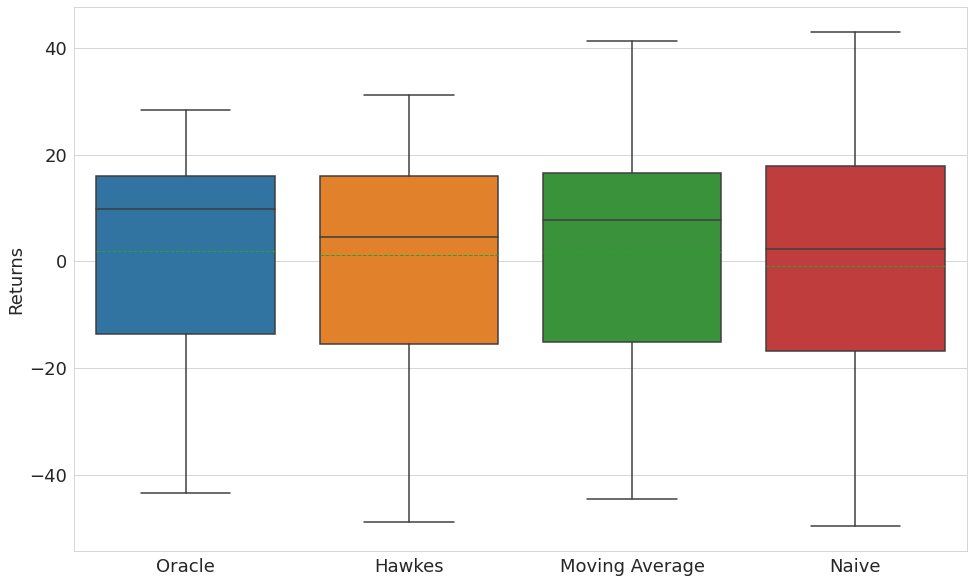

In [20]:
plt.rcParams["figure.figsize"] = (16,10)
order = ['oracle', 'hawkes', 'movingaverage', 'naive']
sns.boxplot(x='method_time_prediction', y='returns', data=plot_df, order=order, showmeans=True, meanline=True)
#increase plot size
plt.ylabel('Returns')
plt.rcParams.update({'font.size': 18})
# delete x label
plt.xlabel('')
# set x ticks labels
plt.xticks([0, 1, 2, 3], ['Oracle', 'Hawkes', 'Moving Average', 'Naive'])
plt.show()

In [22]:
plot_df.groupby('method_time_prediction')['returns'].mean()

method_time_prediction
hawkes           1.210755
movingaverage    1.741408
naive           -0.857980
oracle           1.846335
Name: returns, dtype: float64

In [ ]:
# read json
import json
with open('/home/davide/Desktop/phd/hawkes/data/file_densities_map.json') as f:
    config = json.load(f)


df_map = {
    'timestamp': [],
    'timestamp_density': [],
    'density': [],
}

for k, v in config.items():
    num_densities = len(v)
    timestamp = k.split('_')[2].split('.')[0]
    df_map['timestamp'].extend([float(timestamp)] * num_densities)

    for info_density in v:
        df_map['timestamp_density'].append(pd.Timestamp(info_density[0]).strftime('%H%M%S'))
        df_map['density'].append(int(info_density[1]))

df_map = pd.DataFrame(df_map)
df_map.sort_values(by=['density'], inplace=True, ascending=False)

best_df = df_map.iloc[0:67]
best_df.head()
best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))
df['timestamp_density'] = df['timestamp_density'].apply(lambda x: '000000' if np.isnan(x) else str(int(x)))
df['timestamp_density'] = df['timestamp_density'].str.pad(6, side='left', fillchar='0')
plot_df = df[df['timestamp'].isin(best_df['timestamp']) & (df['timestamp_density'].isin(best_df['timestamp_density']))]

best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))
best_df.to_csv('/home/davide/Desktop/phd/hawkes/data/best_densities.csv', index=False)


/tmp/ipykernel_3441/2500060855.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))
/tmp/ipykernel_3441/2500060855.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))


In [ ]:
plot_df['method_time_prediction'].value_counts()

oracle           67
hawkes           65
movingaverage    64
naive            63
Name: method_time_prediction, dtype: int64

In [ ]:
densities_descriptions = plot_df.groupby(['timestamp', 'timestamp_density']).count().reset_index()
densities_descriptions['timestamp'] = densities_descriptions['timestamp'].apply(lambda x: str(x)[:-2])
densities_descriptions[densities_descriptions['method_time_prediction'] < 4]

,timestamp,timestamp_density,method_time_prediction,bi_level,accuracy,returns
6,1705272255894,223115,2,2,2,2
7,1705356920082,212314,3,3,3,3
16,1705486157408,100410,3,3,3,3
17,1705489579996,104953,3,3,3,3
24,1705789717468,215024,2,2,2,2
28,1705916299647,081343,3,3,3,3
33,1705960026847,210500,2,2,2,2
52,1707216507382,104002,3,3,3,3
55,1707234560871,152856,3,3,3,3


In [ ]:
densities_descriptions=plot_df.groupby(['timestamp', 'timestamp_density']).agg({'method_time_prediction': list, 'accuracy': list})
densities_descriptions[densities_descriptions['method_time_prediction'].apply(lambda x: len(x) == 4)]

method_time_prediction  \
timestamp    timestamp_density                                           
1.705074e+12 151951             [hawkes, movingaverage, naive, oracle]   
1.705077e+12 161544             [hawkes, movingaverage, naive, oracle]   
1.705165e+12 163845             [hawkes, movingaverage, naive, oracle]   
1.705168e+12 174206             [hawkes, movingaverage, naive, oracle]   
1.705262e+12 193416             [hawkes, movingaverage, naive, oracle]   
1.705269e+12 212428             [hawkes, movingaverage, naive, oracle]   
1.705357e+12 220939             [hawkes, movingaverage, naive, oracle]   
1.705365e+12 000334             [hawkes, movingaverage, naive, oracle]   
             231506             [hawkes, movingaverage, naive, oracle]   
1.705379e+12 032503             [hawkes, movingaverage, naive, oracle]   
1.705442e+12 203957             [hawkes, movingaverage, naive, oracle]   
             212215             [hawkes, movingaverage, naive, oracle]   
1.705449e+12 234433             [hawkes, movingaverage, naive, oracle]   
1.705457e+12 003519             [hawkes, movingaverage, naive, oracle]   
1.705497e+12 123947             [hawkes, movingaverage, naive, oracle]   
1.705505e+12 142341             [hawkes, movingaverage, naive, oracle]   
             145915             [hawkes, movingaverage, naive, oracle]   
1.705508e+12 155242             [hawkes, movingaverage, naive, oracle]   
1.705666e+12 091729             [hawkes, movingaverage, naive, oracle]   
1.705790e+12 210726             [hawkes, movingaverage, naive, oracle]   
1.705804e+12 014353             [hawkes, movingaverage, naive, oracle]   
1.705856e+12 153840             [hawkes, movingaverage, naive, oracle]   
             164220             [hawkes, movingaverage, naive, oracle]   
1.705916e+12 090117             [hawkes, movingaverage, naive, oracle]   
1.705925e+12 102636             [hawkes, movingaverage, naive, oracle]   
1.705930e+12 130939             [hawkes, movingaverage, naive, oracle]   
1.705960e+12 202832             [hawkes, movingaverage, naive, oracle]   
             214157             [hawkes, movingaverage, naive, oracle]   
1.706027e+12 154315             [hawkes, movingaverage, naive, oracle]   
1.706035e+12 173320             [hawkes, movingaverage, naive, oracle]   
1.706042e+12 194330             [hawkes, movingaverage, naive, oracle]   
             202116             [hawkes, movingaverage, naive, oracle]   
1.706050e+12 211153             [hawkes, movingaverage, naive, oracle]   
             215227             [hawkes, movingaverage, naive, oracle]   
1.706056e+12 232826             [hawkes, movingaverage, naive, oracle]   
1.706063e+12 012051             [hawkes, movingaverage, naive, oracle]   
1.706087e+12 073851             [hawkes, movingaverage, naive, oracle]   
             081823             [hawkes, movingaverage, naive, oracle]   
1.706094e+12 095440             [hawkes, movingaverage, naive, oracle]   
             104557             [hawkes, movingaverage, naive, oracle]   
1.706110e+12 141550             [hawkes, movingaverage, naive, oracle]   
             150343             [hawkes, movingaverage, naive, oracle]   
1.706133e+12 205851             [hawkes, movingaverage, naive, oracle]   
1.706975e+12 151106             [hawkes, movingaverage, naive, oracle]   
1.707169e+12 202235             [hawkes, movingaverage, naive, oracle]   
1.707228e+12 125518             [hawkes, movingaverage, naive, oracle]   
1.707235e+12 144903             [hawkes, movingaverage, naive, oracle]   
1.707246e+12 163641             [hawkes, movingaverage, naive, oracle]   
             172354             [hawkes, movingaverage, naive, oracle]   
1.707253e+12 195917             [hawkes, movingaverage, naive, oracle]   

                                                                         accuracy  
timestamp    timestamp_density                                                     
1.705074e+12 151951            

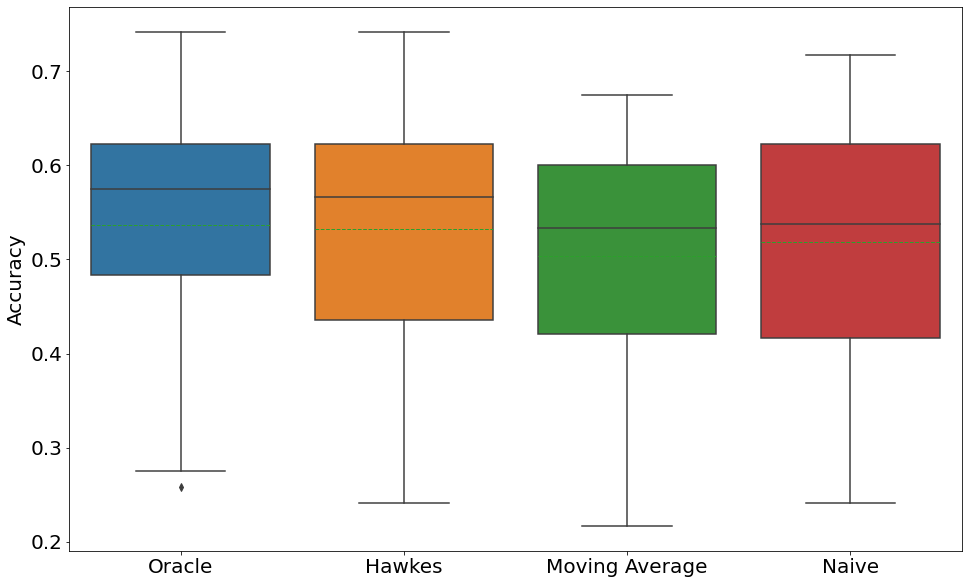

In [ ]:
plt.rcParams["figure.figsize"] = (16,10)
order = ['oracle', 'hawkes', 'movingaverage', 'naive']
sns.boxplot(x='method_time_prediction', y='accuracy', data=plot_df, order=order, showmeans=True, meanline=True)
#increase plot size
plt.ylabel('Accuracy')
plt.rcParams.update({'font.size': 18})
# delete x label
plt.xlabel('')
# set x ticks labels
plt.xticks([0, 1, 2, 3], ['Oracle', 'Hawkes', 'Moving Average', 'Naive'])
plt.show()

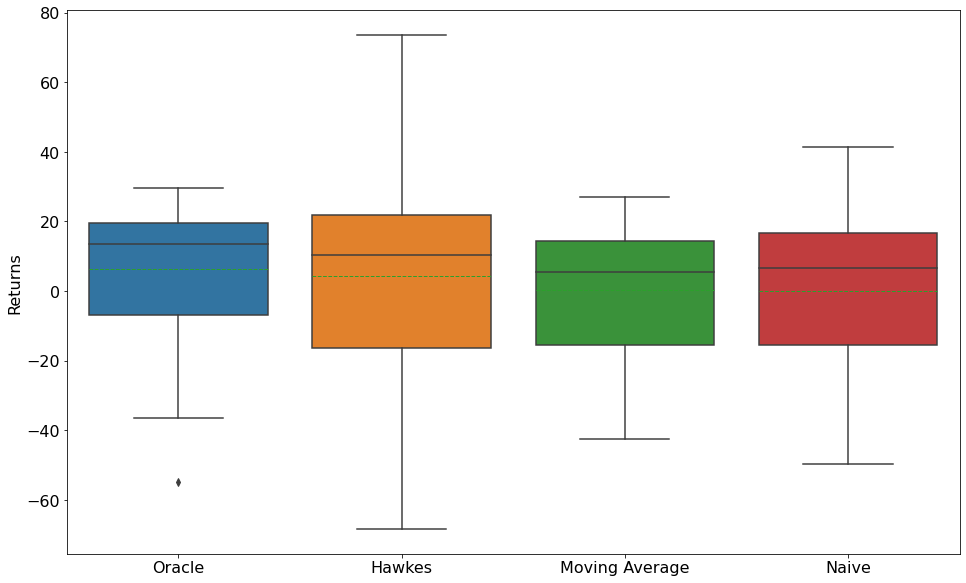

In [ ]:
plt.rcParams["figure.figsize"] = (16,10)
order = ['oracle', 'hawkes', 'movingaverage', 'naive']
sns.boxplot(x='method_time_prediction', y='returns', data=plot_df, order=order, showmeans=True, meanline=True)
#increase plot size
plt.rcParams.update({'font.size': 16})
# delete x label
plt.xlabel('')
plt.ylabel('Returns')
# set x ticks labels
plt.xticks([0, 1, 2, 3], ['Oracle', 'Hawkes', 'Moving Average', 'Naive'])
plt.show()

In [ ]:
df['method_time_prediction'].value_counts()

hawkes           106
movingaverage    106
naive            106
Name: method_time_prediction, dtype: int64

In [ ]:
import json
with open('/home/davide/Desktop/phd/hawkes/data/1705862648312_173406_intensities.json') as f:
    config = json.load(f)

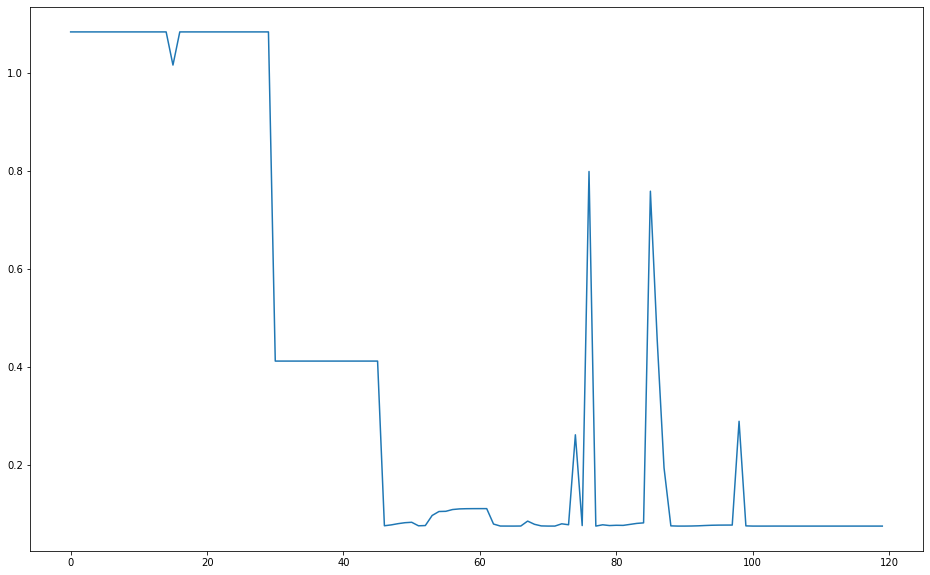

In [ ]:
import matplotlib.pyplot as plt

# boxpot of intensities
plt.rcParams["figure.figsize"] = (16,10)
plt.plot(config)

In [ ]:
import os

result_file_paths = [
    (i, f"/home/davide/Desktop/phd/hawkes/data_{i}min_training/results_all_{i}min_BI8.tsv") for i in ['090',2,5,10,15,20]
]

dfs = []
for i, result_file_path in result_file_paths:
    df = pd.read_csv(result_file_path, sep='\t')
    df['training_minutes'] = i
    df = df[df['method_time_prediction'] == 'hawkes']
    dfs.append(df)

df = pd.concat(dfs)
df.head()

,timestamp,timestamp_density,method_time_prediction,bi_level,accuracy,returns,training_minutes
0,1.705074e+12,151951.0,hawkes,8,0.558333,21.803475,090
4,1.705077e+12,161544.0,hawkes,8,0.500000,3.162698,090
8,1.705165e+12,163845.0,hawkes,8,0.450000,-32.987553,090
12,1.705168e+12,174206.0,hawkes,8,0.391667,-68.318177,090
16,1.705172e+12,182523.0,hawkes,8,0.525000,-8.542695,090


In [ ]:
df[df['training_minutes'] == 15]

,training_minutes,accuracy
0,15,0.558333
4,15,0.475000
8,15,0.425000
12,15,0.425000
16,15,0.625000
...,...,...
424,15,0.333333
428,15,0.350000
436,15,0.583333
440,15,0.258333


In [ ]:
# read json
import json
with open('/home/davide/Desktop/phd/hawkes/data/file_densities_map.json') as f:
    config = json.load(f)


df_map = {
    'timestamp': [],
    'timestamp_density': [],
    'density': [],
}

for k, v in config.items():
    num_densities = len(v)
    timestamp = k.split('_')[2].split('.')[0]
    df_map['timestamp'].extend([float(timestamp)] * num_densities)

    for info_density in v:
        df_map['timestamp_density'].append(pd.Timestamp(info_density[0]).strftime('%H%M%S'))
        df_map['density'].append(int(info_density[1]))

df_map = pd.DataFrame(df_map)
df_map.sort_values(by=['density'], inplace=True, ascending=False)

best_df = df_map.iloc[0:67]
best_df.head()
best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))
df['timestamp_density'] = df['timestamp_density'].apply(lambda x: '000000' if np.isnan(x) else str(int(x)))
df['timestamp_density'] = df['timestamp_density'].str.pad(6, side='left', fillchar='0')
plot_df = df[df['timestamp'].isin(best_df['timestamp']) & (df['timestamp_density'].isin(best_df['timestamp_density']))]


/tmp/ipykernel_20234/3992472598.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['timestamp'] = best_df['timestamp'].apply(lambda x: int(x))


In [ ]:
plot_df['training_minutes'].value_counts()

15     64
20     64
090    62
5      53
10     53
2      52
Name: training_minutes, dtype: int64

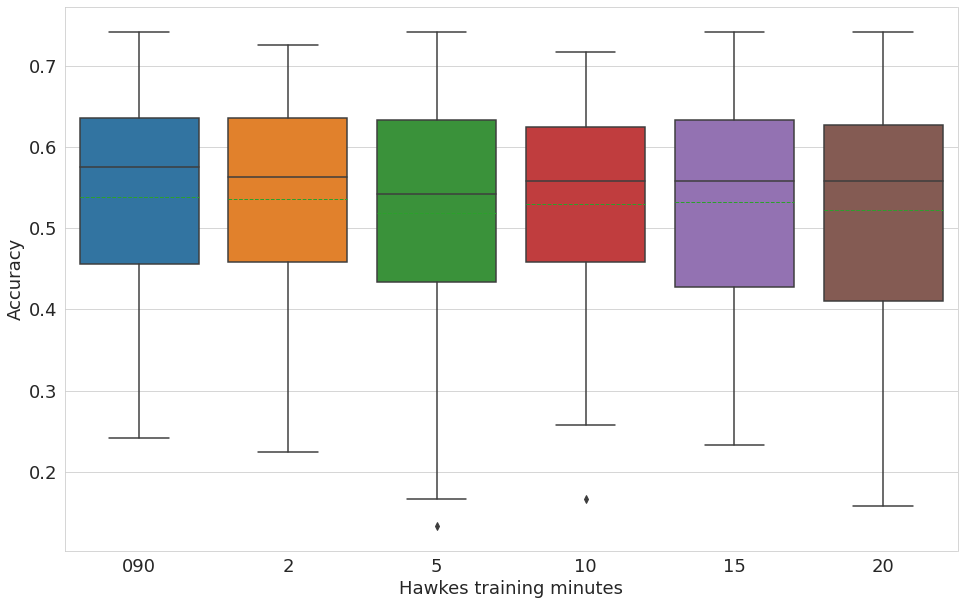

In [ ]:
# boxplot
plt.rcParams["figure.figsize"] = (16,10)
sns.boxplot(x='training_minutes', y='accuracy', data=plot_df,showmeans=True, meanline=True)
# increase font size
#increase plot size
plt.rcParams.update({'font.size': 18})

plt.xlabel('Hawkes training minutes')
plt.ylabel('Accuracy')
#put white background
sns.set_style("whitegrid")

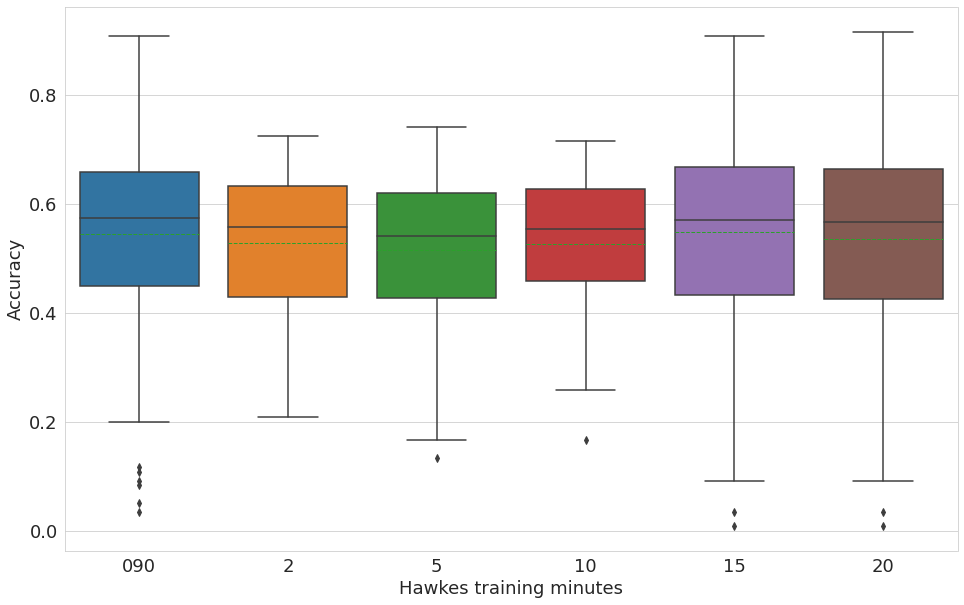

In [ ]:
# boxplot
plt.rcParams["figure.figsize"] = (16,10)
sns.boxplot(x='training_minutes', y='accuracy', data=df,showmeans=True, meanline=True)
# increase font size
#increase plot size
plt.xlabel('Hawkes training minutes')
plt.ylabel('Accuracy')
#put white background
sns.set_style("whitegrid")

In [ ]:
import numpy as np

events = np.array([1, 2, 3, 4, 5, 15, 25, 30])

In [ ]:
def get_logarithmic_distanced_events(events: np.array, offset: int = 0) -> np.array:
    logarithmic_distanced_events = np.zeros(len(events))
    logarithmic_distanced_events[0] = events[0]

    for i in range(1,len(events)):
        logarithmic_distance = np.log10(events[i] - events[i-1]) + offset
        logarithmic_distanced_events[i] = logarithmic_distance + logarithmic_distanced_events[i-1]

    return logarithmic_distanced_events

In [ ]:
a = get_logarithmic_distanced_events(events, 4)
a

array([ 1.     ,  5.     ,  9.     , 13.     , 17.     , 22.     ,
       27.     , 31.69897])

In [ ]:
def get_reconverted_distanced_events(events: np.array, starting_time: float, offset: int = 0) -> np.array:
    reconverted_events = np.zeros(len(events))
    reconverted_events[0] = starting_time

    for i in range(1,len(events)):
        reconverted_events[i] = 10 ** (events[i] - events[i-1] - offset) + reconverted_events[i-1]

    return reconverted_events

In [ ]:
get_reconverted_distanced_events(a, 1, 4)

array([ 1.,  2.,  3.,  4.,  5., 15., 25., 30.])